## **[문제 1] Fashion MNIST 데이터 정규화를 위한 Mean과 Std. 값 찾기**

In [2]:
import os
from pathlib import Path
import torch
import wandb
from torch import nn

from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import transforms

BASE_PATH = str(Path().resolve().parent.parent)  # BASE_PATH: /Users/yhhan/git/link_dl

import sys

sys.path.append(BASE_PATH)

from _01_code._99_common_utils.utils import get_num_cpu_cores, is_linux, is_windows

data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])

imgs = torch.stack([img_t for img_t, _ in f_mnist_train], dim=3) # train데이터에서 추출한 이미지 텐서들을 4번째 차원에 쌓아 하나의 텐서로 만듦
print(imgs.view(1, -1).mean(dim=-1)) # 1차원 텐서로 모든 이미지의 픽셀 값들을 펼치고, 그 값들의 평균을 출력
print(imgs.view(1, -1).std(dim=-1)) # 1차원 텐서로 모든 이미지의 픽셀 값들을 펼치고, 그 값들의 표준편차를 출력

100.0%


Extracting C:\Users\민수\git\link_dl\_00_data\j_fashion_mnist\FashionMNIST\raw\train-images-idx3-ubyte.gz to C:\Users\민수\git\link_dl\_00_data\j_fashion_mnist\FashionMNIST\raw



100.0%


Extracting C:\Users\민수\git\link_dl\_00_data\j_fashion_mnist\FashionMNIST\raw\train-labels-idx1-ubyte.gz to C:\Users\민수\git\link_dl\_00_data\j_fashion_mnist\FashionMNIST\raw



100.0%


Extracting C:\Users\민수\git\link_dl\_00_data\j_fashion_mnist\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to C:\Users\민수\git\link_dl\_00_data\j_fashion_mnist\FashionMNIST\raw



100.0%


Extracting C:\Users\민수\git\link_dl\_00_data\j_fashion_mnist\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to C:\Users\민수\git\link_dl\_00_data\j_fashion_mnist\FashionMNIST\raw

tensor([0.2860])
tensor([0.3530])


**· 데이터셋의 이미지들을 모두 추출하여 모든 이미지의 픽셀 값들을 한 차원에 펼친 후, 그 값들의 평균과 표준편차를 계산하는 방식으로 다음과 같은 Mean값과 Std값을 찾을 수 있었다.  
[Mean : 0.2860]  
[Std  : 0.3530]**

## **[문제 2] Fashion MNIST 데이터에 대하여 CNN 학습시키기**

In [ ]:
import os
from pathlib import Path
import torch
import wandb
from torch import nn

from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import transforms

BASE_PATH = str(Path(__file__).resolve().parent.parent.parent)  # BASE_PATH: /Users/yhhan/git/link_dl
print(BASE_PATH)

import sys

sys.path.append(BASE_PATH)

from _01_code._99_common_utils.utils import get_num_cpu_cores, is_linux, is_windows


def get_fashion_mnist_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
    f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])

    print("Num Train Samples: ", len(f_mnist_train))
    print("Num Validation Samples: ", len(f_mnist_validation))
    print("Sample Shape: ", f_mnist_train[0][0].shape)  # torch.Size([1, 28, 28])

    num_data_loading_workers = get_num_cpu_cores() if is_linux() or is_windows() else 0
    print("Number of Data Loading Workers:", num_data_loading_workers)

    train_data_loader = DataLoader(
        dataset=f_mnist_train, batch_size=wandb.config.batch_size, shuffle=True,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    validation_data_loader = DataLoader(
        dataset=f_mnist_validation, batch_size=wandb.config.batch_size,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    f_mnist_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=0.2860, std=0.3530),
    )

    return train_data_loader, validation_data_loader, f_mnist_transforms


def get_fashion_mnist_test_data():
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    f_mnist_test_images = datasets.FashionMNIST(data_path, train=False, download=True)
    f_mnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transforms.ToTensor())

    print("Num Test Samples: ", len(f_mnist_test))
    print("Sample Shape: ", f_mnist_test[0][0].shape)  # torch.Size([1, 28, 28])

    test_data_loader = DataLoader(dataset=f_mnist_test, batch_size=len(f_mnist_test))

    f_mnist_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=0.2860, std=0.3530),
    )

    return f_mnist_test_images, test_data_loader, f_mnist_transforms


if __name__ == "__main__":
    config = {'batch_size': 2048, }
    wandb.init(mode="disabled", config=config)

    train_data_loader, validation_data_loader, f_mnist_transforms = get_fashion_mnist_data()
    print()
    f_mnist_test_images, test_data_loader, f_mnist_transforms = get_fashion_mnist_test_data()

**· 이 코드에 보이는 것처럼 transforms.Normalize의 mean과 std값은 문제 1에서 찾은 값으로 변경하였다.**

In [ ]:
import argparse


def get_parser():
  parser = argparse.ArgumentParser()

  parser.add_argument(
    "--wandb", action=argparse.BooleanOptionalAction, default=True, help="True or False"
  )

  parser.add_argument(
    "-b", "--batch_size", type=int, default=512, help="Batch size (int, default: 512)"
  )

  parser.add_argument(
    "-e", "--epochs", type=int, default=30, help="Number of training epochs (int, default:30)"
  )

  parser.add_argument(
    "-r", "--learning_rate", type=float, default=5e-4, help="Learning rate (float, default: 5e-4)"
  )

  parser.add_argument(
    "-v", "--validation_intervals", type=int, default=3,
    help="Number of training epochs between validations (int, default: 3)"
  )

  parser.add_argument(
    "-p", "--early_stop_patience", type=int, default=3,
    help="Number of early stop patience (int, default: 3)"
  )

  parser.add_argument(
    "-d", "--early_stop_delta", type=float, default=0.0001,
    help="Delta value of early stop (float, default: 0.0001)"
  )

  return parser

**· 이렇게 ArgParser를 수정하여 사용하였다.**

In [ ]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path

BASE_PATH = str(Path(__file__).resolve().parent.parent.parent) # BASE_PATH: /Users/yhhan/git/link_dl
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

import sys
sys.path.append(BASE_PATH)

from _01_code._08_fcn_best_practice.c_trainer import ClassificationTrainer
from _02_homeworks.homework_3.a_fashion_mnist_data_copy import get_fashion_mnist_data
from _02_homeworks.homework_3.e_arg_parser import get_parser


def get_cnn_model():
  class MyModel(nn.Module):
    def __init__(self, in_channels, n_output):
      super().__init__()

      self.model = nn.Sequential(
        # Convolution Layer 1
        nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),  # 크기 28x28 -> 14x14
        
        # Convolution Layer 2
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),  # 크기 14x14 -> 7x7
        
        # Flatten
        nn.Flatten(),
        
        # Fully Connected Layer
        nn.Linear(3136, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        
        # Output Layer
        nn.Linear(128, n_output)
      )

    def forward(self, x):
      x = self.model(x)
      return x

  # 1 * 28 * 28
  my_model = MyModel(in_channels=1, n_output=10)

  return my_model


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta
  }

  project_name = "cnn_mnist"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="mnist experiment with cnn",
    tags=["cnn", "mnist"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  train_data_loader, validation_data_loader, mnist_transforms = get_fashion_mnist_data()
  model = get_cnn_model()
  model.to(device)
  wandb.watch(model)

  from torchinfo import summary
  # 모델 구조 출력
  summary(model=model, input_size=(1, 1, 28, 28))

  # Adam, weight_decay 사용
  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=1e-4)

  classification_trainer = ClassificationTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, mnist_transforms,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  classification_trainer.train_loop()

  wandb.finish()


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args()
  main(args)
  # python _01_code/_07_cnn/a_mnist_train_cnn.py --wandb -b 2048 -r 1e-3 -v 10
  # python _01_code/_07_cnn/a_mnist_train_cnn.py --no-wandb -b 2048 -r 1e-3 -v 10

**· 이렇게 모델 학습 코드를 구성하였다. _02_homeworks/homework_3/a_fashion_mnist_data.py의 데이터와 수정한 ArgParser를 가져와 사용했으며, _08_fcn_best_practice의 c_trainer.py를 그대로 가져와 trainer로 사용하였다. CNN모델은 2개의 Convolution Layer와 Flatten, Fully Connected Layer, Output Layer 순서로 구성되도록 구현하였고, 각 Convolution Layer에는 BatchNormalize와 ReLU, MaxPool 을 차례로 추가하여 구성하였다. 그리고 Fully Connected Layer에는 Dropout을 추가하였다. 이 내용과 사용한 기법들과 하이퍼파라미터를 종합하여 다음과 같이 정리하였다.  
[Learning_Rate : 5e-4]  
[Batch_Size : 512]  
[epochs : 30]  
[validation_intervals : 3]  
[early_stop_patience : 3]  
[early_stop_delta : 0.0001]  
[Normalization Type : Batch Normalization]  
[Dropout Rate : 0.5]  
[optimizer : Adam]  
[Weight Decay Value : 1e-4]**

**· 이렇게 구성한 모델의 구조를 torchinfo모듈을 사용하여 다음과 같이 출력하였다.**

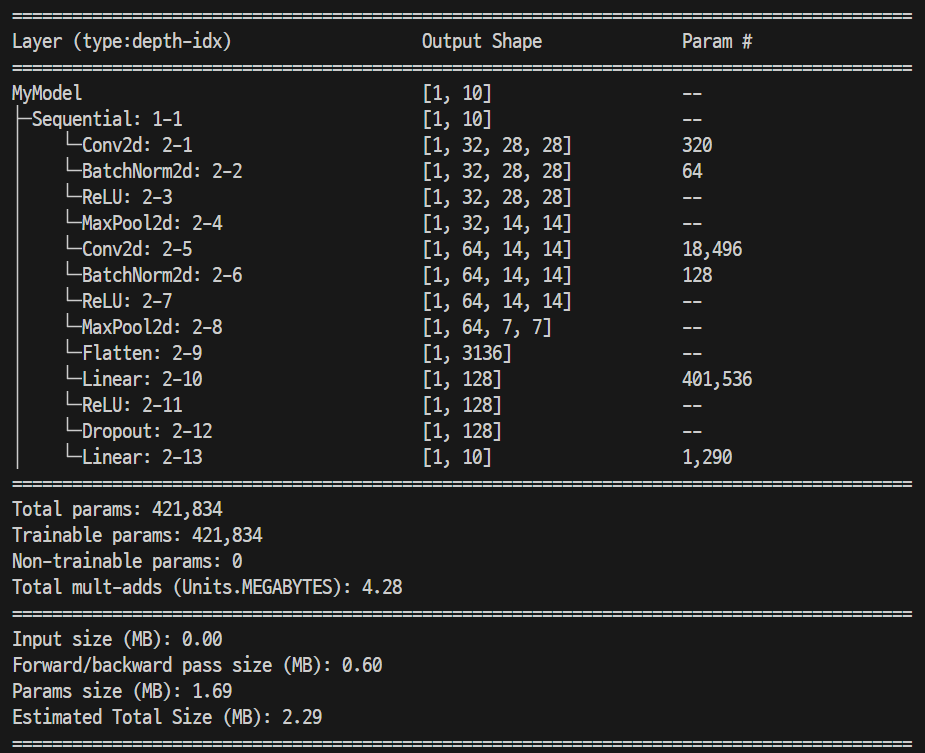

**· 학습 완료 후, 최종 Validation Accuracy는 92.68% 이다.**

## **[문제 3] 학습 완료된 모델로 테스트 데이터 Accuracy 확인하기**

In [ ]:
import numpy as np
import torch
import os

from matplotlib import pyplot as plt
from pathlib import Path

BASE_PATH = str(Path(__file__).resolve().parent.parent.parent)  # BASE_PATH: /Users/yhhan/git/link_dl
CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

import sys
sys.path.append(BASE_PATH)

from _02_homeworks.homework_3.a_mnist_train_cnn import get_cnn_model
from _02_homeworks.homework_3.d_tester_copy import ClassificationTester
from _02_homeworks.homework_3.a_fashion_mnist_data_copy import get_fashion_mnist_test_data


def main():
  mnist_test_images, test_data_loader, mnist_transforms = get_fashion_mnist_test_data()

  test_model = get_cnn_model()
  classification_tester = ClassificationTester(
    "mnist", test_model, test_data_loader, mnist_transforms, CHECKPOINT_FILE_PATH
  )
  classification_tester.test()

  print()

  img, label = mnist_test_images[0]
  print("     LABEL:", label)
  plt.imshow(img)
  plt.show()

  # torch.tensor(np.array(mnist_test_images[0][0])).unsqueeze(dim=0).unsqueeze(dim=0).shape: (1, 1, 28, 28)
  output = classification_tester.test_single(
    torch.tensor(np.array(mnist_test_images[0][0])).unsqueeze(dim=0).unsqueeze(dim=0)
  )
  print("PREDICTION:", output)


if __name__ == "__main__":
  main()


**· 이렇게 모델 테스트 코드를 구성하였다. _02_homeworks/homework_3/a_fashion_mnist_data.py의 데이터와 문제2에서 학습 완료한 모델을 가져와 테스트했으며, _08_fcn_best_practice의 d_tester.py를 그대로 가져와 tester로 사용하였다. 이 코드로 테스트하여 출력된 결과는 다음과 같다.**

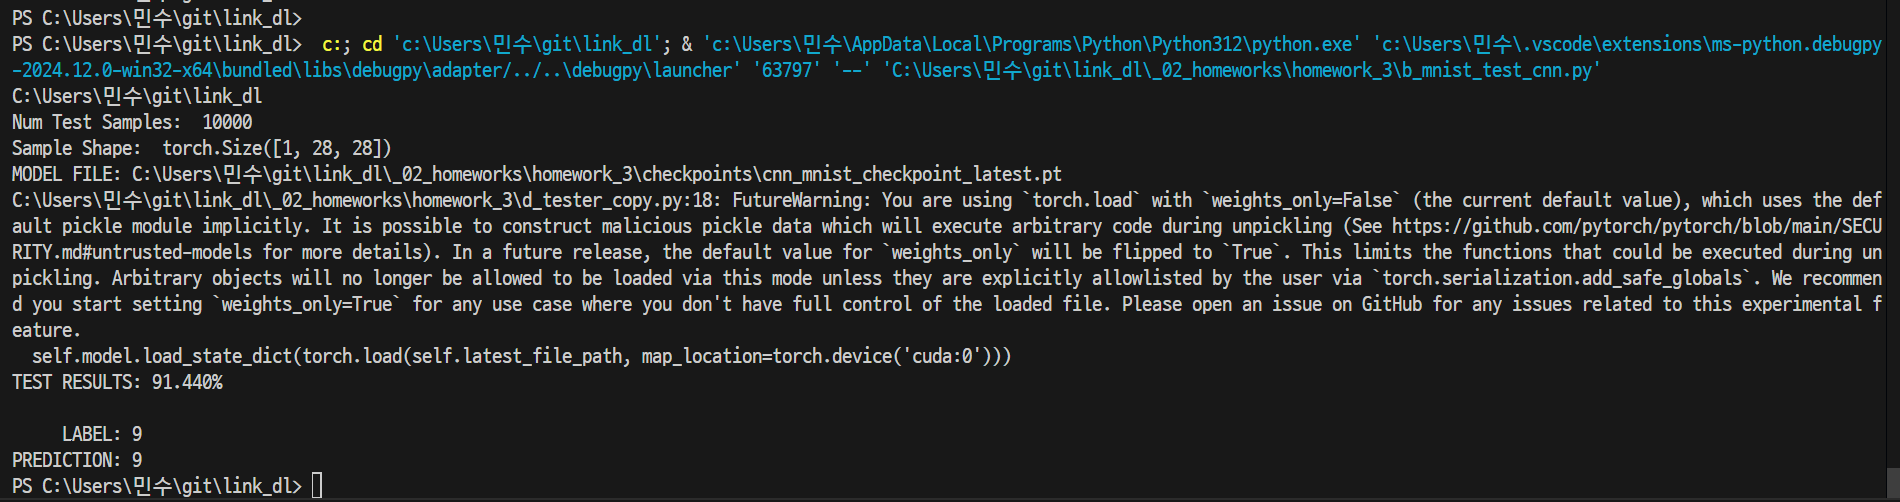

**· 위의 출력값에서 알 수 있듯이 Test Accuracy는 91.44% 이다.**

## **[문제 4] 샘플 테스트 데이터 분류 예측 결과 확인하기**

In [ ]:
import numpy as np
import torch
import os
import random

from matplotlib import pyplot as plt
from pathlib import Path

BASE_PATH = str(Path(__file__).resolve().parent.parent.parent)  # BASE_PATH: /Users/yhhan/git/link_dl
CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

import sys
sys.path.append(BASE_PATH)

from _02_homeworks.homework_3.a_mnist_train_cnn import get_cnn_model
from _02_homeworks.homework_3.d_tester_copy import ClassificationTester
from _02_homeworks.homework_3.a_fashion_mnist_data_copy import get_fashion_mnist_test_data


def main():
  mnist_test_images, test_data_loader, mnist_transforms = get_fashion_mnist_test_data()

  test_model = get_cnn_model()
  classification_tester = ClassificationTester(
    "mnist", test_model, test_data_loader, mnist_transforms, CHECKPOINT_FILE_PATH
  )

  print()

  samples = random.sample(range(0, 10000), 10)  # 0부터 9999 까지의 중복되지 않는 10개의 숫자를 샘플링
  
  count = 1
  for n in samples:
    n=random.randint(0, 9999)
    img, label = mnist_test_images[n]
    print(f"[case {count}]")
    print("     LABEL:", label)

    # torch.tensor(np.array(mnist_test_images[0][0])).unsqueeze(dim=0).unsqueeze(dim=0).shape: (1, 1, 28, 28)
    output = classification_tester.test_single(
      torch.tensor(np.array(mnist_test_images[n][0])).unsqueeze(dim=0).unsqueeze(dim=0)
    )
    print("PREDICTION:", output)
    print()
    
    plt.imshow(img)
    plt.show()
    
    count += 1


if __name__ == "__main__":
  main()

**· 문제 3의 모델 테스트 코드를 위와 같이 수정하여, 10000개의 테스트 데이터 중 10개를 임의로 선택해 해당 이미지와 레이블, 학습 완료된 모델을 사용하여 분류한 해당 이미지의 분류 예측 결과를 출력하였다. 출력 결과와 해석은 아래와 같다.**

**[case 1]**

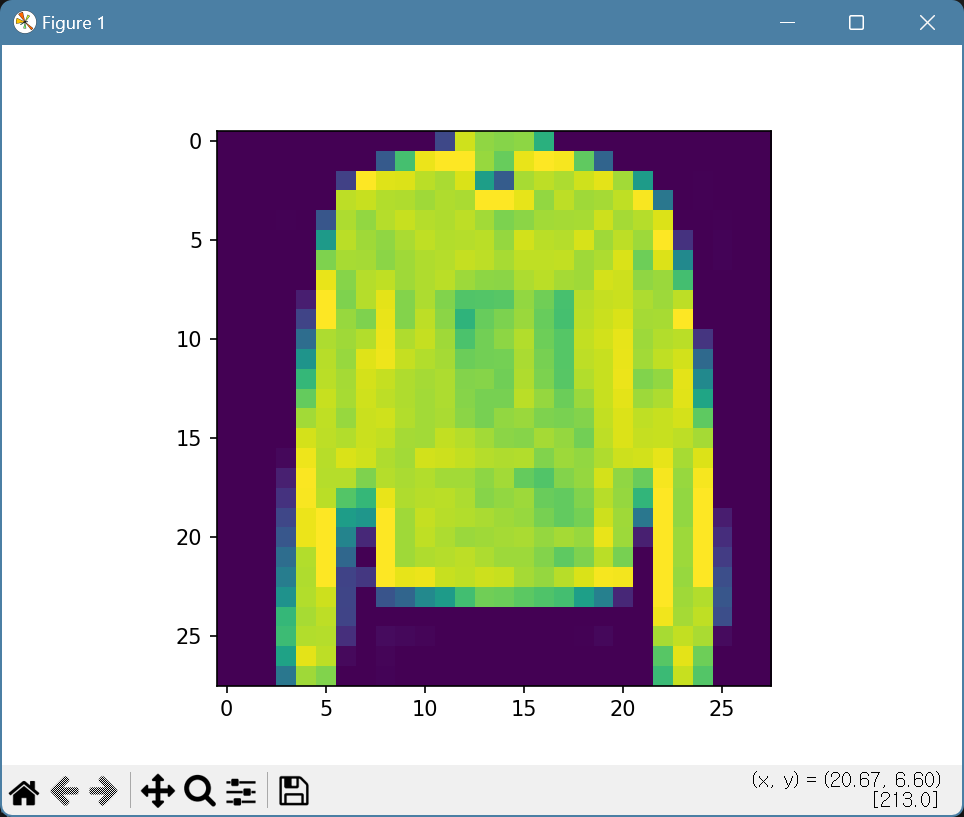

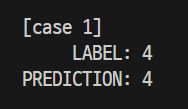

**· 정확히 코트를 코트로 분류하였다.**

**[case 2]**

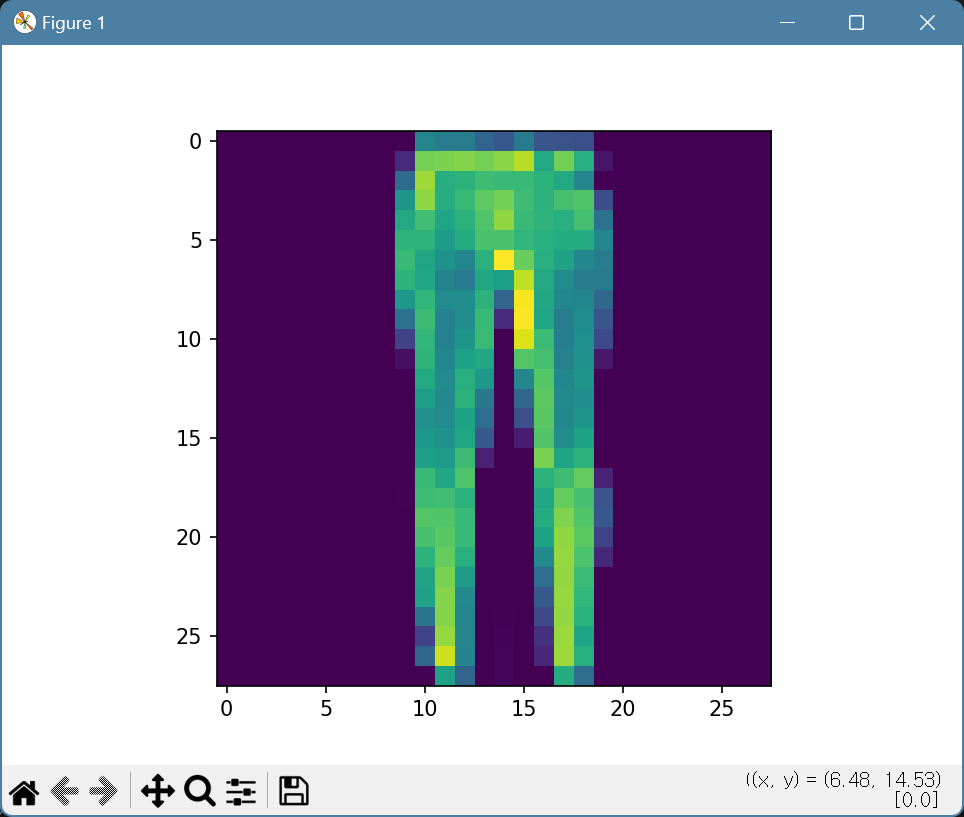

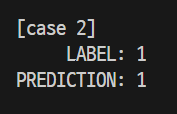

**· 정확히 바지를 바지로 분류하였다.**

**[case 3]**

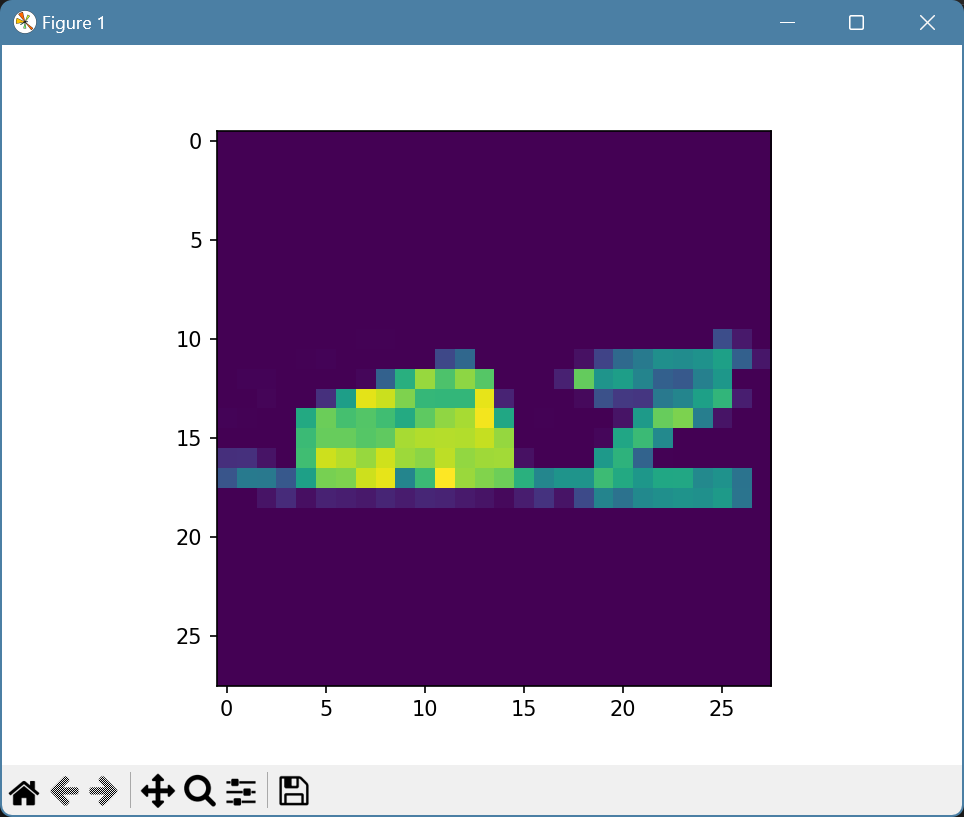

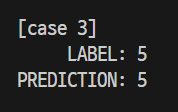

**· 정확히 샌들을 샌들로 분류하였다.**

**[case 4]**

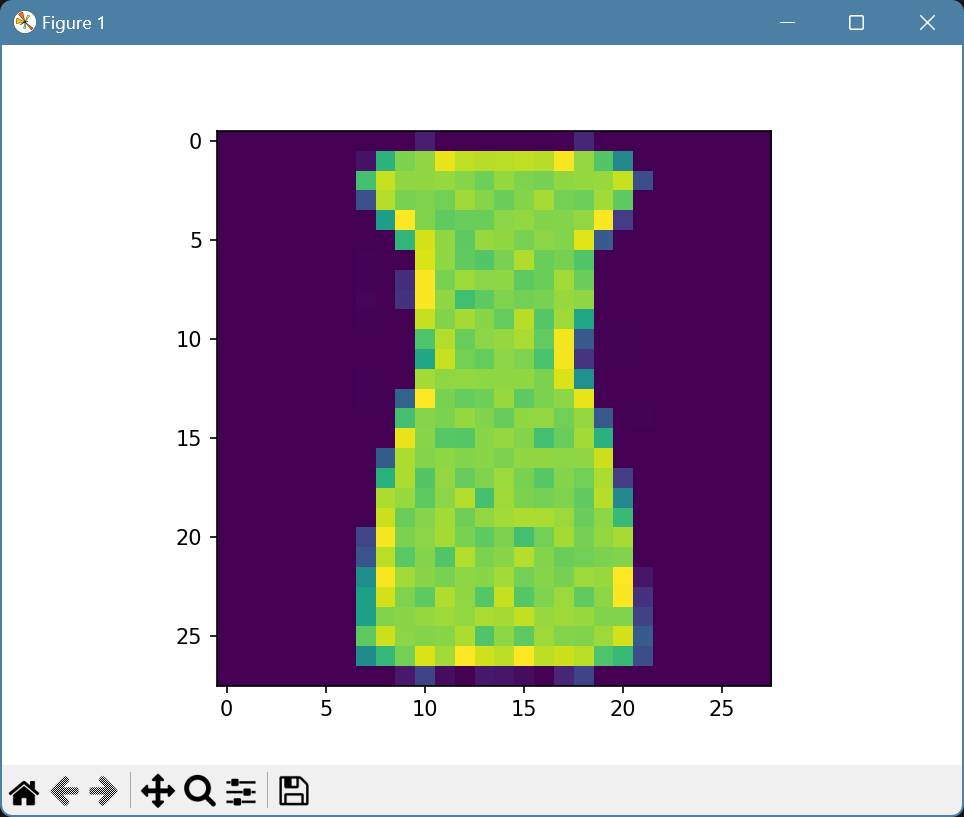

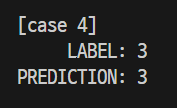

**· 정확히 원피스를 원피스로 분류하였다.**

**[case 5]**

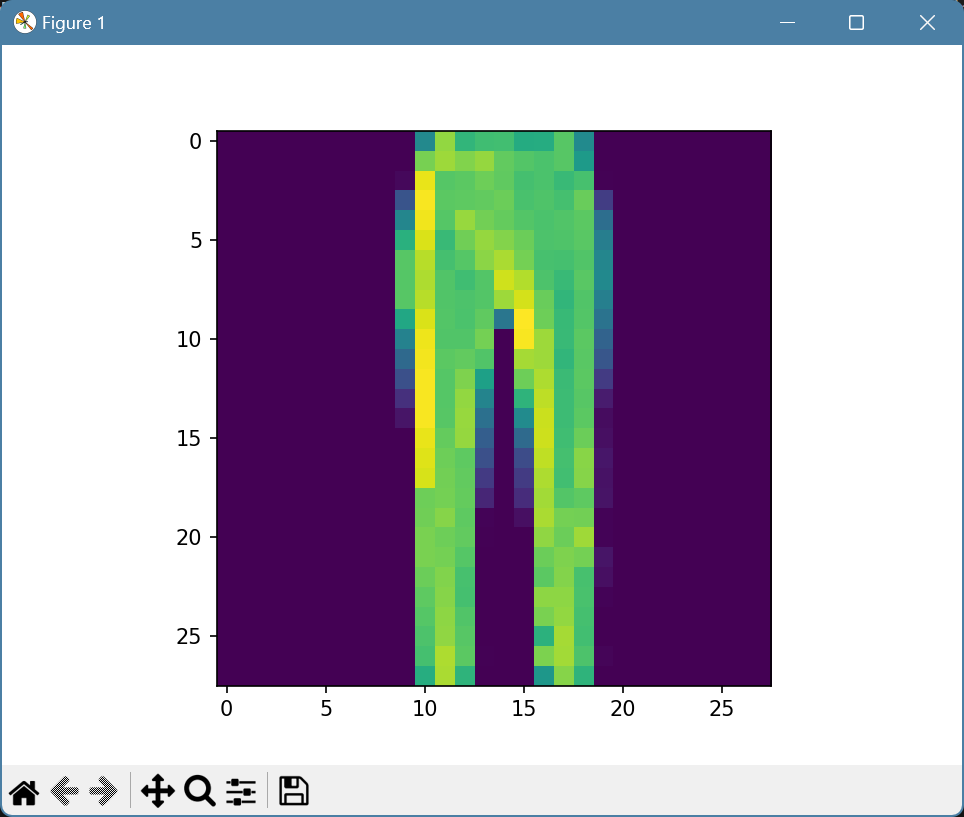

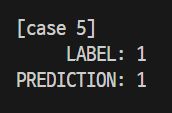

**· 정확히 바지를 바지로 분류하였다.**

**[case 6]**

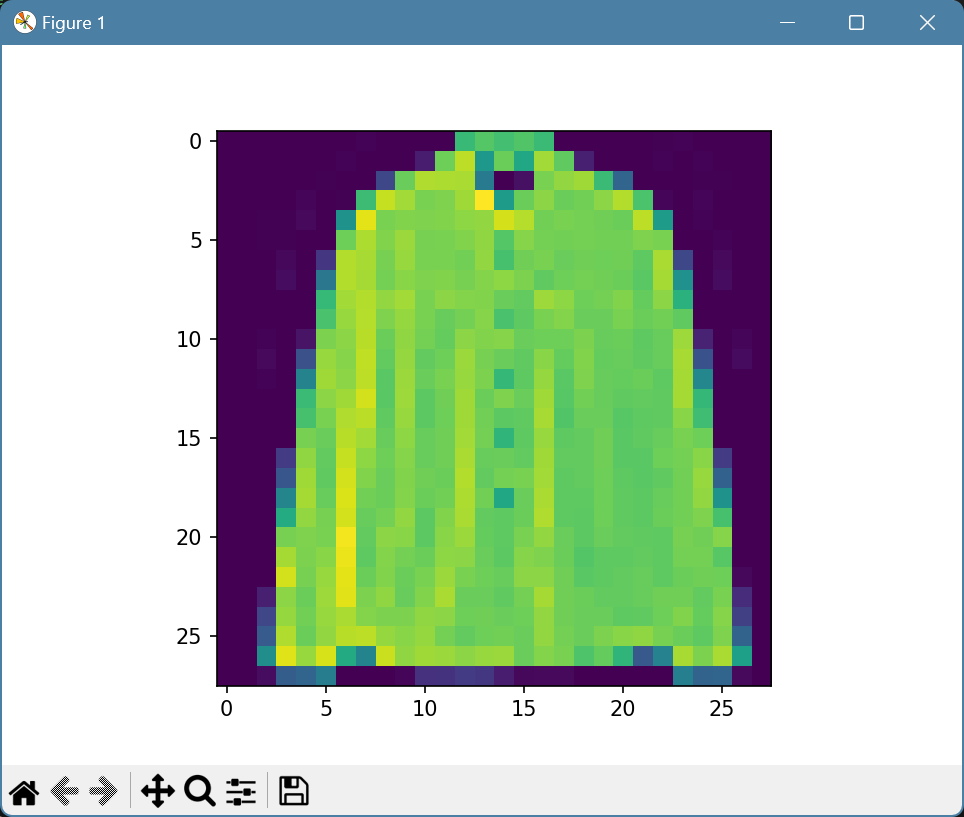

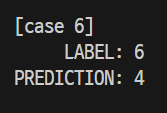

**· 셔츠를 코트로 분류하였다. 틀린 이유를 해석해보자면, case 1의 이미지가 코트이고 이번 케이스 이미지가 셔츠인데, 육안으로 봤을 때는 코트 이미지 보다도 오히려 이번 셔츠 이미지가 더욱 두께감이 있어 보인다. 그래서 모델이 이번 이미지를 코트로 인식한 것으로 해석된다.**

**[case 7]**

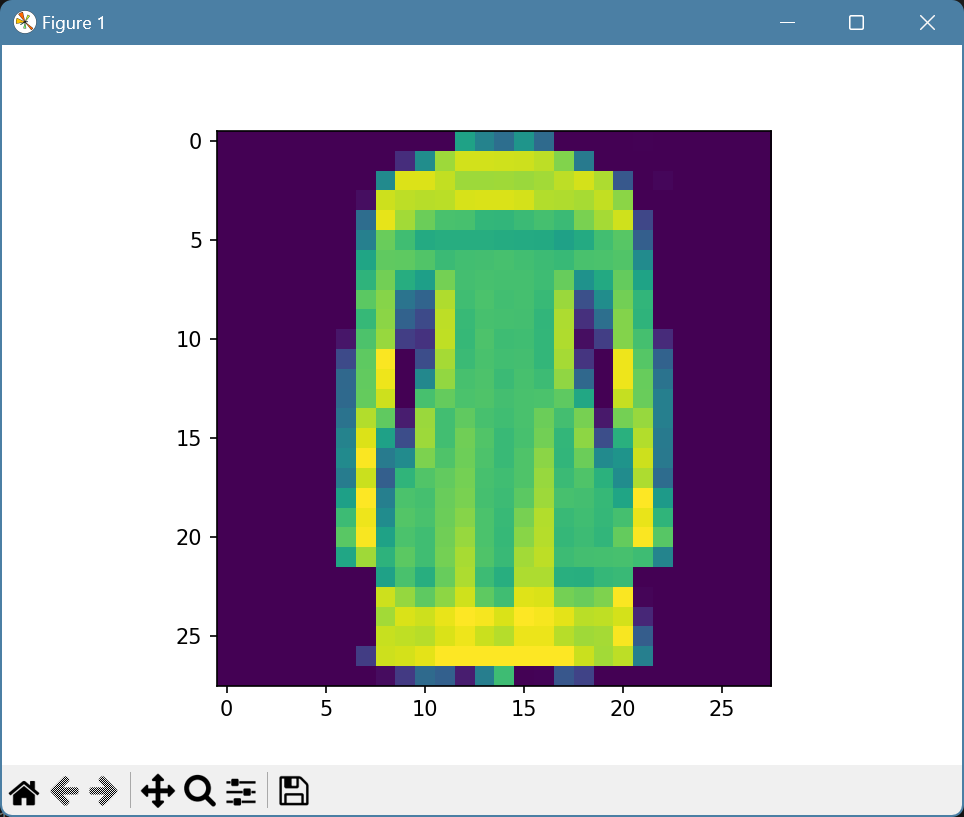

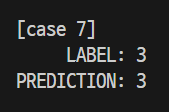

**· 정확히 원피스를 원피스로 분류하였다.**

**[case 8]**

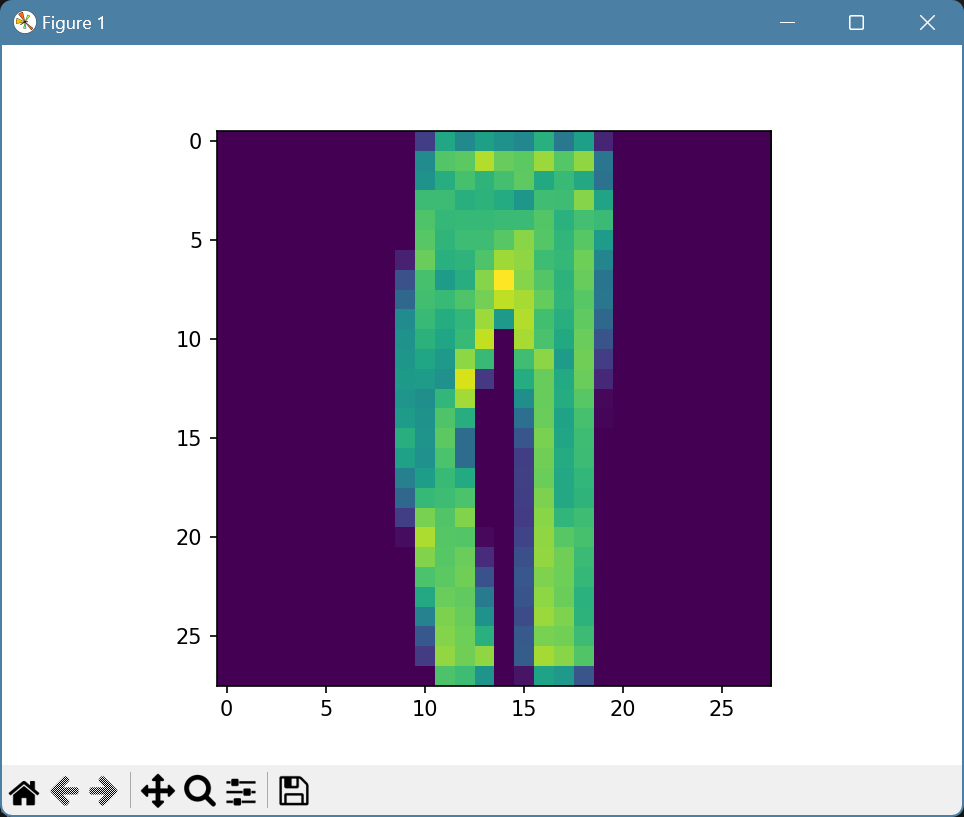

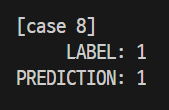

**· 정확히 바지를 바지로 분류하였다.**

**[case 9]**

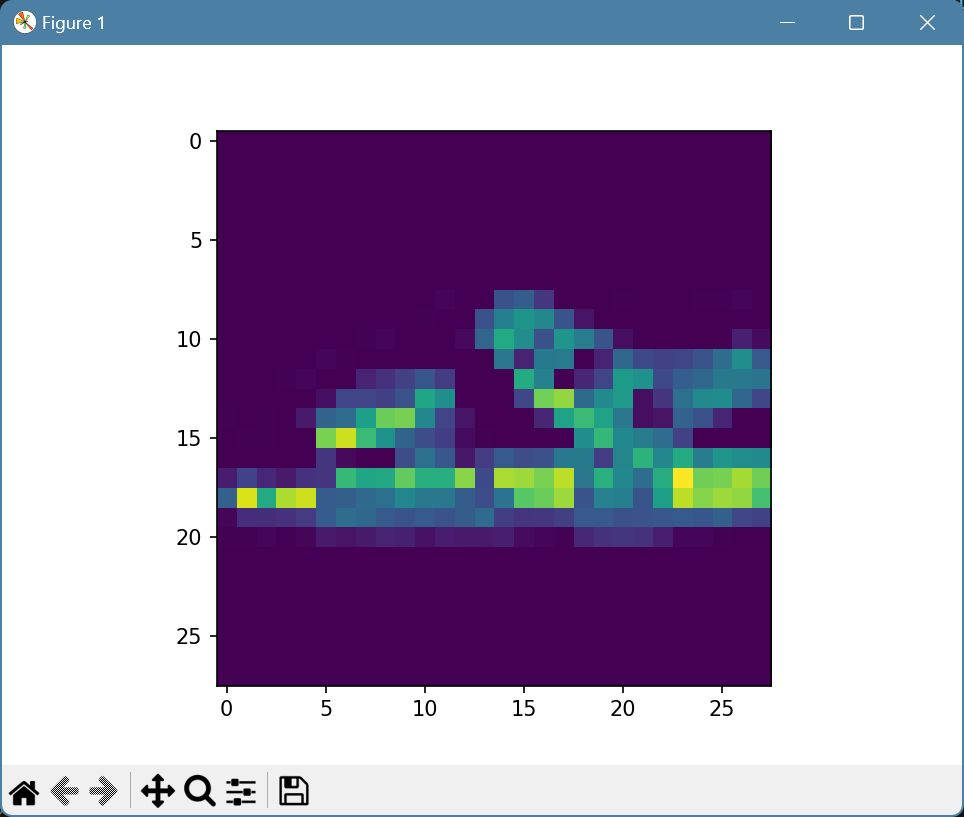

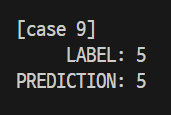

**· 정확히 샌들을 샌들로 분류하였다.**

**[case 10]**

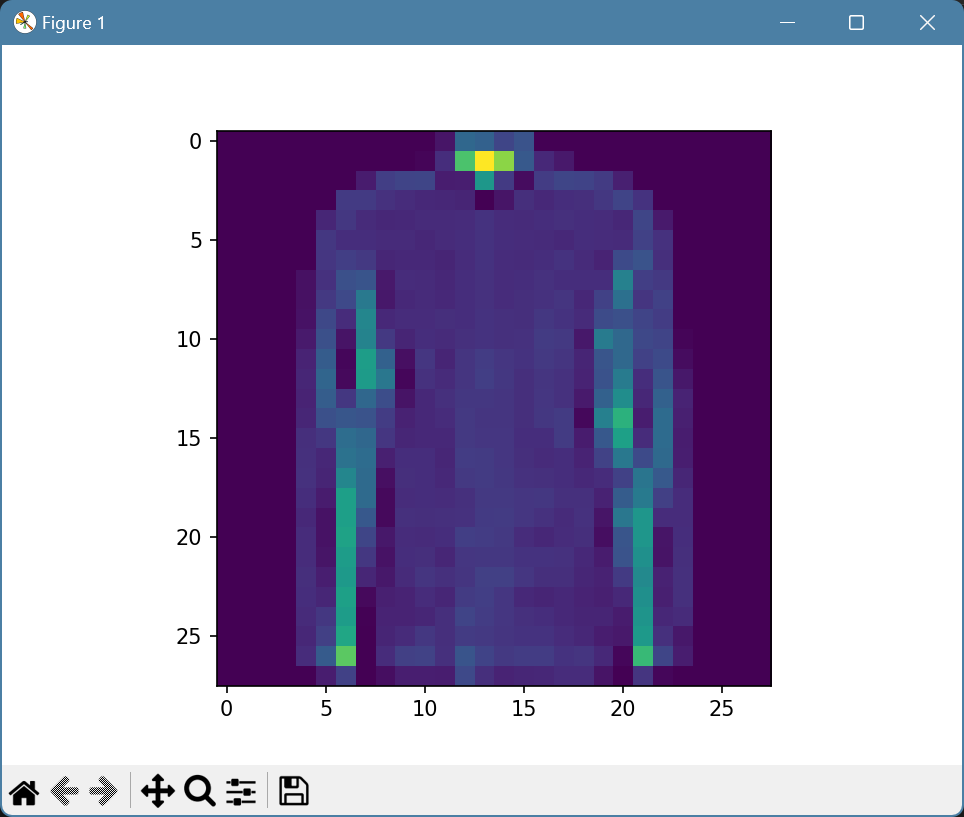

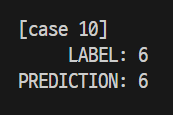

**· 정확히 셔츠를 셔츠로 분류하였다.**

## **숙제 후기**

**· 모델의 성능을 올리기 위한 여러 기법들의 사용과 하이퍼파라미터들의 값 조정을 통한 효과를 육안으로 확인할 수 있는 과제였어서 힘든 과정도 있었지만 많이 배우고 만족스러웠던 시간들이었다.**